In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
! pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Twitter 2015

## Data Pre-processing

In [51]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

### Read dataset file

In [52]:
import pandas as pd
import numpy as np

train_filename = "/content/drive/MyDrive/NLP Project/Datasets/Twitter2015/tweetstrain2015.csv"
test_filename = "/content/drive/MyDrive/NLP Project/Datasets/Twitter2015/tweetstest2015.csv"

df_train = pd.read_csv(train_filename)
df_test = pd.read_csv(test_filename)

In [53]:
df_train.columns.values.tolist()

['Unnamed: 0.1', 'Unnamed: 0', 'tweetId', 'tweetText', 'label']

In [54]:
df_train = df_train.drop('Unnamed: 0', axis=1)
df_train = df_train.drop('tweetId', axis=1)

In [55]:
df_test = df_test.drop('Unnamed: 0', axis=1)
df_test = df_test.drop('tweetId', axis=1)

In [56]:
df_train = df_train.rename(columns={'tweetText': 'text'})
df_test = df_test.rename(columns={'tweetText': 'text'})

In [57]:
df_train.head()

,Unnamed: 0.1,text,label
0,0,se acuerdan de la pel cula el despu de ana rec...,fake
1,1,milenagimon miren sandi en ny tremenda imagen ...,fake
2,2,buena la foto del hurac n sandi recuerda la pe...,fake
3,3,scari shit hurrican ny http co e jlbufh,fake
4,4,fave place world nyc hurrican sandi statueofli...,fake


In [58]:
df_test.head()

,Unnamed: 0.1,text,label
0,0,kereeen rt shyman eclips iss http co je hcfpvfn,fake
1,1,absolut beauti rt shyman eclips iss http co oq...,fake
2,2,shyman eclips iss http co c vfboscrj wow amaz,fake
3,3,eclips iss http co en otvsu,fake
4,4,ebonfigli clips vue de l iss autr chose http c...,fake


In [59]:
df_train.loc[df_train.label == 'fake'].sample(10)

,Unnamed: 0.1,text,label
14021,14021,offlcialcnn break malaysian flight found bay h...,fake
432,432,statu liberti today new york newyork hurrican ...,fake
7155,7155,jesu hurricanesandi look mean hope everyon new...,fake
3182,3182,kid comrad fanamokoena hurrican sandi http co ...,fake
4396,4396,rememb simba sandi lionk newyork http co oajcocjc,fake
13255,13255,marvellousp underwat bedroom poseidon undersea...,fake
5329,5329,sandi http co skxzscg,fake
1356,1356,shark sandi nopow http co hjthso,fake
5481,5481,hurrican sandi look mean http co pnxzboi,fake
2888,2888,soldier continu guard tomb unknown soldier thr...,fake


### Get the values of DataFrame

In [60]:
train_labels = df_train['label'].tolist()
train_text = df_train['text'].tolist()

test_labels = df_test['label'].tolist()
test_text = df_test['text'].tolist()

assert len(train_labels) == len(train_text)
assert len(test_labels) == len(test_text)

print("len(train_text) = {}, len(test_text) = {}".format(len(train_text), len(test_text)))

len(train_text) = 14277, len(test_text) = 3755


In [61]:
def unique(list1):
 
    # initialize a null list
    unique_list = []
 
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    # print list
    for x in unique_list:
        print (x)

In [62]:
unique(train_labels)

fake
real


### Get values indices

In [63]:
def format_label_value(labels):
    """
    Formats a list of labels to corresponding numeric values.
    """
    format_label_list = []

    for label in labels:
        if label == "fake":
            format_label_list.append(0)
        elif label == "real":
            format_label_list.append(1)
        
    
    return format_label_list

In [64]:
train_labels = format_label_value(train_labels)
test_labels = format_label_value(test_labels)

In [65]:
len(train_labels)

14277

## GPT-J Tokenization & Input Formatting

### GPT-J. Tokenization

In [66]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

model_name = "ydshieh/tiny-random-gptj-for-sequence-classification"

tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer.pad_token = tokenizer.eos_token


In [67]:
# Print the original sentence.
print('Original: ', train_text[0])
print("len(Original) = ", len(train_text[0]))
print("\n")

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(train_text[0]))
print("len(Tokenized) = ", len(tokenizer.tokenize(train_text[0])))
print("\n")

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_text[0])))
print("len(Token IDs) = ", len(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_text[0]))))
print("\n")

Original:  se acuerdan de la pel cula el despu de ana recuerda lo que est pasando con el hurac n sandi http co jqqerpwn
len(Original) =  108


Tokenized:  ['se', 'Ġac', 'u', 'er', 'd', 'an', 'Ġde', 'Ġl', 'a', 'Ġp', 'el', 'Ġc', 'ul', 'a', 'Ġ', 'el', 'Ġdes', 'p', 'u', 'Ġde', 'Ġan', 'a', 'Ġrec', 'u', 'er', 'd', 'a', 'Ġl', 'o', 'Ġqu', 'e', 'Ġest', 'Ġp', 'as', 'and', 'o', 'Ġcon', 'Ġ', 'el', 'Ġh', 'ur', 'ac', 'Ġn', 'Ġs', 'and', 'i', 'Ġh', 't', 't', 'p', 'Ġco', 'Ġj', 'q', 'q', 'er', 'p', 'wn']
len(Tokenized) =  57


Token IDs:  [399, 772, 85, 199, 68, 220, 353, 250, 65, 224, 248, 212, 306, 65, 159, 248, 541, 80, 85, 353, 326, 65, 489, 85, 199, 68, 65, 250, 79, 755, 69, 928, 224, 226, 325, 79, 313, 159, 248, 232, 260, 257, 254, 203, 325, 73, 232, 84, 84, 80, 767, 536, 81, 81, 199, 80, 574]
len(Token IDs) =  57




### Input Formatting for GPT-J

In [68]:
import logging

# Set logger to avoid warning `token indices sequence length is longer than the specified maximum sequence length for this model (1017 > 512)`
logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)


def text_to_id(tokenizer, text_list):
    """
    It is a function to transform text to id.
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    """
    ids_list = []
    
    for item in text_list:
        # Sentence to id and add [CLS] and [SEP]
        encoded_item = tokenizer.encode(item, add_special_tokens=True)
        ids_list.append(encoded_item)
    
    return ids_list

In [69]:
train_text_ids = text_to_id(tokenizer, train_text)
test_text_ids = text_to_id(tokenizer, test_text)


# Print sentence 0, now as a list of IDs.
print('Original: {}\n'.format(train_text[0]))
print('Token IDs: {}\n'.format(train_text_ids[0]))
print("len(train_text_ids) = {}\n".format(len(train_text_ids)))
print("len(test_text_ids) = {}".format(len(test_text_ids)))

Original: se acuerdan de la pel cula el despu de ana recuerda lo que est pasando con el hurac n sandi http co jqqerpwn

Token IDs: [399, 772, 85, 199, 68, 220, 353, 250, 65, 224, 248, 212, 306, 65, 159, 248, 541, 80, 85, 353, 326, 65, 489, 85, 199, 68, 65, 250, 79, 755, 69, 928, 224, 226, 325, 79, 313, 159, 248, 232, 260, 257, 254, 203, 325, 73, 232, 84, 84, 80, 767, 536, 81, 81, 199, 80, 574]

len(train_text_ids) = 14277

len(test_text_ids) = 3755


In [70]:
print('Train: max sentence length: ', max([len(sen) for sen in train_text_ids]))
print('Train: Min sentence length: ', min([len(sen) for sen in train_text_ids]))
print('Test: max sentence length: ', max([len(sen) for sen in test_text_ids]))
print('Test: Min sentence length: ', min([len(sen) for sen in test_text_ids]))

Train: max sentence length:  1969
Train: Min sentence length:  10
Test: max sentence length:  775
Test: Min sentence length:  11


### Padding & Truncating

In [71]:
def padding_truncating(input_ids_list, max_length):
    """
    It is a function to perform padding and truncating
    @param input_ids_list: <List> text_ids
    @param max_length: <Integer> the number we wanna the sentence to be padding or truncating
    @return: processed input_ids_list
    """
    processed_input_ids_list = []
    for item in input_ids_list:
        seq_list = []
        
        if len(item) < max_length:
            # Define a seq_list with the length of max_length
            seq_list = [0] * (max_length - len(item))
            item = item + seq_list
        
        elif len(item) >= max_length:
            item = item[:max_length]
            
        processed_input_ids_list.append(item)
    
    return processed_input_ids_list

In [72]:
train_padding_list = padding_truncating(train_text_ids, max_length=50)
test_padding_list = padding_truncating(test_text_ids, max_length=50)

### Attention Masks

In [73]:
def get_attention_masks(pad_input_ids_list):
    """
    It is a function to get attention masks:
    
    - If a token ID is 0, then it's padding, set the mask to 0.
    - If a token ID is > 0, then it's a real token, set the mask to 1.
    """
    attention_masks_list = []
    
    for item in pad_input_ids_list:
        
        mask_list = []
        for subitem in item:
            if subitem > 0:
                mask_list.append(1)
            else:
                mask_list.append(0)
        attention_masks_list.append(mask_list)
    
    return attention_masks_list

In [74]:
train_attention_masks = get_attention_masks(train_padding_list)
test_attention_masks = get_attention_masks(test_padding_list)

assert len(train_text) == len(train_labels) == len(train_attention_masks) == len(train_padding_list), "Training data length mismatch"
assert len(test_text) == len(test_labels) == len(test_attention_masks) == len(test_padding_list), "Testing data length mismatch"


In [75]:
print(len(train_text), len(train_labels), len(train_attention_masks), len(train_padding_list))


14277 14277 14277 14277


### Split train dataset into train_dataset and validation_dataset


In [76]:
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_padding_list, validation_padding_list, train_labels, validation_labels, train_attention_masks, validation_attention_masks = train_test_split(train_padding_list, train_labels, train_attention_masks, random_state=2020, test_size=0.1)


In [77]:
assert len(train_labels) == len(train_attention_masks) == len(train_padding_list)
assert len(validation_labels) == len(validation_attention_masks) == len(validation_padding_list)
assert len(test_labels) == len(test_attention_masks) == len(test_padding_list)

In [78]:
print("len(train_labels) = {}\nlen(validation_labels) = {}\nlen(test_labels) = {}".format(len(train_labels), len(validation_labels), len(test_labels)))


len(train_labels) = 12849
len(validation_labels) = 1428
len(test_labels) = 3755


### Convert to Dataset

Convert all the List objects to tensor

In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Convert all inputs and labels into torch tensors, the required datatype for our model.
train_inputs = torch.tensor(train_padding_list)
validation_inputs = torch.tensor(validation_padding_list)
test_inputs = torch.tensor(test_padding_list)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)

train_masks = torch.tensor(train_attention_masks)
validation_masks = torch.tensor(validation_attention_masks)
test_masks = torch.tensor(test_attention_masks)

Form the Dataset with torch.tensor

In [80]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Create the DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

## Train GPT-J Text Classification Model

In [81]:
from transformers import AutoModelForSequenceClassification, AdamW, LongformerConfig
import torch

# Load BertForSequenceClassification, the pretrained BERT model
model = AutoModelForSequenceClassification.from_pretrained(
    "ydshieh/tiny-random-gptj-for-sequence-classification",  # Use the 12-layer BERT model, with an uncased vocab.
     num_labels = 2,      # The number of output labels -- 2 for binary classification.
                    # You can increase this for multi-class tasks.   
     output_attentions = False, # Whether the model returns attentions weights.
     output_hidden_states = False, # Whether the model returns all hidden-states.
)
AutoModelForSequenceClassification
model.to(device)

GPTJForSequenceClassification(
  (transformer): GPTJModel(
    (wte): Embedding(1000, 32)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): GPTJBlock(
        (ln_1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (k_proj): Linear(in_features=32, out_features=32, bias=False)
          (v_proj): Linear(in_features=32, out_features=32, bias=False)
          (q_proj): Linear(in_features=32, out_features=32, bias=False)
          (out_proj): Linear(in_features=32, out_features=32, bias=False)
        )
        (mlp): GPTJMLP(
          (fc_in): Linear(in_features=32, out_features=128, bias=True)
          (fc_out): Linear(in_features=128, out_features=32, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (1): GPTJBlock(
        (ln_1): L

### Optimizer & Learning Rate Scheduler

In [82]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [83]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
print("total_steps = {}".format(total_steps))

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

total_steps = 3216


### Train

In [84]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [85]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [86]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [87]:
import random

# Set the seed value all over the place to make this reproducible.
seed_val = 12345

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(epochs):
    
    ##########################################
    #               Training                 #
    ##########################################
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 10 batches.
        if step % 10 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear the gradients.
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we have provided the `labels`.
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end. 
        # `loss` is a Tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
        total_loss += loss.item()

        # Perform a `backward` pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
        
    ##########################################
    #               Validation               #
    ##########################################
    # After the completion of each training epoch, measure our performance on our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to device
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            # token_type_ids is the same as the "segment ids", which differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        # flat_accuracy(y_pred, y_true)
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    10  of    804.    Elapsed: 0:00:03.
  Batch    20  of    804.    Elapsed: 0:00:03.
  Batch    30  of    804.    Elapsed: 0:00:03.
  Batch    40  of    804.    Elapsed: 0:00:04.
  Batch    50  of    804.    Elapsed: 0:00:04.
  Batch    60  of    804.    Elapsed: 0:00:04.
  Batch    70  of    804.    Elapsed: 0:00:04.
  Batch    80  of    804.    Elapsed: 0:00:05.
  Batch    90  of    804.    Elapsed: 0:00:05.
  Batch   100  of    804.    Elapsed: 0:00:05.
  Batch   110  of    804.    Elapsed: 0:00:06.
  Batch   120  of    804.    Elapsed: 0:00:06.
  Batch   130  of    804.    Elapsed: 0:00:06.
  Batch   140  of    804.    Elapsed: 0:00:07.
  Batch   150  of    804.    Elapsed: 0:00:07.
  Batch   160  of    804.    Elapsed: 0:00:07.
  Batch   170  of    804.    Elapsed: 0:00:08.
  Batch   180  of    804.    Elapsed: 0:00:08.
  Batch   190  of    804.    Elapsed: 0:00:09.
  Batch   200  of    804.    Elapsed: 0:00:09.
  Batch   210  of

### Plot

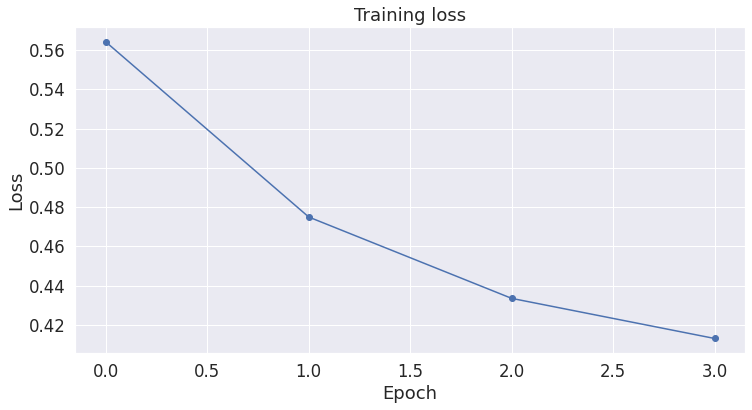

In [88]:
import matplotlib.pyplot as plt

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

### Evaluation

In [89]:
print('Predicting labels for {:,} test sentences...'.format(len(test_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions, true_labels = [], []

# Predict 
total_correct = 0
for idx, batch in enumerate(test_dataloader):
    
    print("Batch {}".format(idx + 1))
    
    # Add batch to device
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    # Get the prediction probability
    logits = outputs[0]
    
    # Get the prediction label
    pred = torch.argmax(logits, dim=1)
   
    # Get the number of correct predictions in this batch
    batch_correct = (pred == b_labels).sum().item()
    print("Batch correct = {}\n".format(batch_correct))
    
    # Accumulate the number of correct predictions over all batches
    total_correct += batch_correct
    
    # Append the predicted labels and true labels for this batch
    predictions.append(pred.cpu().numpy())
    true_labels.append(b_labels.cpu().numpy())
    

print('DONE.')
print("Total correct = ", total_correct)
print("Test accuracy = {0:.2f}".format(total_correct / len(test_inputs)))

# Concatenate the predicted labels and true labels over all batches
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Print classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(true_labels, predictions))
print(confusion_matrix(true_labels, predictions))

Predicting labels for 3,755 test sentences...
Batch 1
Batch correct = 15

Batch 2
Batch correct = 15

Batch 3
Batch correct = 13

Batch 4
Batch correct = 15

Batch 5
Batch correct = 15

Batch 6
Batch correct = 12

Batch 7
Batch correct = 15

Batch 8
Batch correct = 15

Batch 9
Batch correct = 8

Batch 10
Batch correct = 6

Batch 11
Batch correct = 7

Batch 12
Batch correct = 2

Batch 13
Batch correct = 2

Batch 14
Batch correct = 2

Batch 15
Batch correct = 1

Batch 16
Batch correct = 9

Batch 17
Batch correct = 8

Batch 18
Batch correct = 11

Batch 19
Batch correct = 16

Batch 20
Batch correct = 16

Batch 21
Batch correct = 16

Batch 22
Batch correct = 16

Batch 23
Batch correct = 16

Batch 24
Batch correct = 16

Batch 25
Batch correct = 16

Batch 26
Batch correct = 16

Batch 27
Batch correct = 16

Batch 28
Batch correct = 16

Batch 29
Batch correct = 16

Batch 30
Batch correct = 16

Batch 31
Batch correct = 16

Batch 32
Batch correct = 8

Batch 33
Batch correct = 7

Batch 34
Batch co

# Twitter 2016

## Data Pre-processing

In [90]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

### Read dataset file

In [91]:
import pandas as pd
import numpy as np

train_filename = "/content/drive/MyDrive/NLP Project/Datasets/Twitter2016/tweetstrain2016.csv"
test_filename = "/content/drive/MyDrive/NLP Project/Datasets/Twitter2016/tweetstest2016.csv"

df_train = pd.read_csv(train_filename)
df_test = pd.read_csv(test_filename)

In [92]:
df_train.columns.values.tolist()

['Unnamed: 0.1', 'Unnamed: 0', 'tweetId', 'tweetText', 'label']

In [93]:
df_train = df_train.drop('Unnamed: 0', axis=1)
df_train = df_train.drop('tweetId', axis=1)

In [94]:
df_test = df_test.drop('Unnamed: 0', axis=1)
df_test = df_test.drop('tweetId', axis=1)

In [95]:
df_train = df_train.rename(columns={'tweetText': 'text'})
df_test = df_test.rename(columns={'tweetText': 'text'})

In [96]:
df_train.head()

,Unnamed: 0.1,text,label
0,0,need fed solv bostonbomb chan http co exqtpzqqbg,fake
1,1,pic comparison boston suspect sunil tripathi f...,fake
2,2,complet convinc sunil tripathi fellow http co ...,fake
3,3,brutal lo que se pued conseguir en colaboraci ...,fake
4,4,chan bomb throw http co diyso lxqm http co nxb...,fake


In [97]:
df_test.head()

,Unnamed: 0.1,text,label
0,0,antiterror arabianblood russianfeder syria dai...,fake
1,1,n http co ws jxmgj,fake
2,2,http co lz awn nhttp co gvsduzmaxa,fake
3,3,http co kg quidotf http co dkfmxppje,fake
4,4,nthe airstrik isi ammunit depot near talbiseh ...,fake


In [98]:
df_train.loc[df_train.label == 'fake'].sample(10)

,Unnamed: 0.1,text,label
3275,3275,hurrican real sandi http co xactwxon,fake
1855,1855,nyc sandi http co koiz zg,fake
4225,4225,thetroyreport even statu liberti afraid hurric...,fake
1087,1087,rt komalminha well insan imag sandi http co rd...,fake
1345,1345,newyork sandi holyshit instapropheci http co w...,fake
15559,15559,hero syrian boy risk life rescu girl assad reg...,fake
172,172,rt sodagrrl imag bomb suspect http co gebhz nc...,fake
166,166,go around boston bomb suspect boston prayforbo...,fake
2185,2185,sandi http co slcsv,fake
3210,3210,aar allo shark swim front yard flood home brig...,fake


### Get the values of DataFrame

In [99]:
train_labels = df_train['label'].tolist()
train_text = df_train['text'].tolist()

test_labels = df_test['label'].tolist()
test_text = df_test['text'].tolist()

assert len(train_labels) == len(train_text)
assert len(test_labels) == len(test_text)

print("len(train_text) = {}, len(test_text) = {}".format(len(train_text), len(test_text)))

len(train_text) = 15629, len(test_text) = 2177


In [100]:
def unique(list1):
 
    # initialize a null list
    unique_list = []
 
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    # print list
    for x in unique_list:
        print (x)

In [101]:
unique(train_labels)

fake
real


### Get values indices

In [102]:
def format_label_value(labels):
    """
    Formats a list of labels to corresponding numeric values.
    """
    format_label_list = []

    for label in labels:
        if label == "fake":
            format_label_list.append(0)
        elif label == "real":
            format_label_list.append(1)
        
    
    return format_label_list

In [103]:
train_labels = format_label_value(train_labels)
test_labels = format_label_value(test_labels)

In [104]:
len(train_labels)

15629

## GPT-J Tokenization & Input Formatting

### GPT-J. Tokenization

In [105]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

model_name = "ydshieh/tiny-random-gptj-for-sequence-classification"

tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer.pad_token = tokenizer.eos_token


In [106]:
# Print the original sentence.
print('Original: ', train_text[0])
print("len(Original) = ", len(train_text[0]))
print("\n")

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(train_text[0]))
print("len(Tokenized) = ", len(tokenizer.tokenize(train_text[0])))
print("\n")

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_text[0])))
print("len(Token IDs) = ", len(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_text[0]))))
print("\n")

Original:  need fed solv bostonbomb chan http co exqtpzqqbg
len(Original) =  48


Tokenized:  ['n', 'e', 'ed', 'Ġf', 'ed', 'Ġs', 'ol', 'v', 'Ġb', 'ost', 'on', 'b', 'om', 'b', 'Ġch', 'an', 'Ġh', 't', 't', 'p', 'Ġco', 'Ġex', 'q', 't', 'p', 'z', 'q', 'q', 'b', 'g']
len(Tokenized) =  30


Token IDs:  [78, 69, 204, 214, 204, 203, 270, 86, 219, 419, 200, 66, 249, 66, 370, 220, 232, 84, 84, 80, 767, 377, 81, 84, 80, 90, 81, 81, 66, 71]
len(Token IDs) =  30




### Input Formatting for GPT-J

In [107]:
import logging

# Set logger to avoid warning `token indices sequence length is longer than the specified maximum sequence length for this model (1017 > 512)`
logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)


def text_to_id(tokenizer, text_list):
    """
    It is a function to transform text to id.
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    """
    ids_list = []
    
    for item in text_list:
        # Sentence to id and add [CLS] and [SEP]
        encoded_item = tokenizer.encode(item, add_special_tokens=True)
        ids_list.append(encoded_item)
    
    return ids_list

In [108]:
train_text_ids = text_to_id(tokenizer, train_text)
test_text_ids = text_to_id(tokenizer, test_text)


# Print sentence 0, now as a list of IDs.
print('Original: {}\n'.format(train_text[0]))
print('Token IDs: {}\n'.format(train_text_ids[0]))
print("len(train_text_ids) = {}\n".format(len(train_text_ids)))
print("len(test_text_ids) = {}".format(len(test_text_ids)))

Original: need fed solv bostonbomb chan http co exqtpzqqbg

Token IDs: [78, 69, 204, 214, 204, 203, 270, 86, 219, 419, 200, 66, 249, 66, 370, 220, 232, 84, 84, 80, 767, 377, 81, 84, 80, 90, 81, 81, 66, 71]

len(train_text_ids) = 15629

len(test_text_ids) = 2177


In [109]:
print('Train: max sentence length: ', max([len(sen) for sen in train_text_ids]))
print('Train: Min sentence length: ', min([len(sen) for sen in train_text_ids]))
print('Test: max sentence length: ', max([len(sen) for sen in test_text_ids]))
print('Test: Min sentence length: ', min([len(sen) for sen in test_text_ids]))

Train: max sentence length:  77
Train: Min sentence length:  10
Test: max sentence length:  1564
Test: Min sentence length:  9


### Padding & Truncating

In [110]:
def padding_truncating(input_ids_list, max_length):
    """
    It is a function to perform padding and truncating
    @param input_ids_list: <List> text_ids
    @param max_length: <Integer> the number we wanna the sentence to be padding or truncating
    @return: processed input_ids_list
    """
    processed_input_ids_list = []
    for item in input_ids_list:
        seq_list = []
        
        if len(item) < max_length:
            # Define a seq_list with the length of max_length
            seq_list = [0] * (max_length - len(item))
            item = item + seq_list
        
        elif len(item) >= max_length:
            item = item[:max_length]
            
        processed_input_ids_list.append(item)
    
    return processed_input_ids_list

In [111]:
train_padding_list = padding_truncating(train_text_ids, max_length=50)
test_padding_list = padding_truncating(test_text_ids, max_length=50)

### Attention Masks

In [112]:
def get_attention_masks(pad_input_ids_list):
    """
    It is a function to get attention masks:
    
    - If a token ID is 0, then it's padding, set the mask to 0.
    - If a token ID is > 0, then it's a real token, set the mask to 1.
    """
    attention_masks_list = []
    
    for item in pad_input_ids_list:
        
        mask_list = []
        for subitem in item:
            if subitem > 0:
                mask_list.append(1)
            else:
                mask_list.append(0)
        attention_masks_list.append(mask_list)
    
    return attention_masks_list

In [113]:
train_attention_masks = get_attention_masks(train_padding_list)
test_attention_masks = get_attention_masks(test_padding_list)

assert len(train_text) == len(train_labels) == len(train_attention_masks) == len(train_padding_list), "Training data length mismatch"
assert len(test_text) == len(test_labels) == len(test_attention_masks) == len(test_padding_list), "Testing data length mismatch"


In [114]:
print(len(train_text), len(train_labels), len(train_attention_masks), len(train_padding_list))


15629 15629 15629 15629


### Split train dataset into train_dataset and validation_dataset


In [115]:
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_padding_list, validation_padding_list, train_labels, validation_labels, train_attention_masks, validation_attention_masks = train_test_split(train_padding_list, train_labels, train_attention_masks, random_state=2020, test_size=0.1)


In [116]:
assert len(train_labels) == len(train_attention_masks) == len(train_padding_list)
assert len(validation_labels) == len(validation_attention_masks) == len(validation_padding_list)
assert len(test_labels) == len(test_attention_masks) == len(test_padding_list)

In [117]:
print("len(train_labels) = {}\nlen(validation_labels) = {}\nlen(test_labels) = {}".format(len(train_labels), len(validation_labels), len(test_labels)))


len(train_labels) = 14066
len(validation_labels) = 1563
len(test_labels) = 2177


### Convert to Dataset

Convert all the List objects to tensor

In [118]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Convert all inputs and labels into torch tensors, the required datatype for our model.
train_inputs = torch.tensor(train_padding_list)
validation_inputs = torch.tensor(validation_padding_list)
test_inputs = torch.tensor(test_padding_list)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)

train_masks = torch.tensor(train_attention_masks)
validation_masks = torch.tensor(validation_attention_masks)
test_masks = torch.tensor(test_attention_masks)

Form the Dataset with torch.tensor

In [119]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Create the DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

## Train GPT-J Text Classification Model

In [120]:
from transformers import AutoModelForSequenceClassification, AdamW, LongformerConfig
import torch

# Load BertForSequenceClassification, the pretrained BERT model
model = AutoModelForSequenceClassification.from_pretrained(
    "ydshieh/tiny-random-gptj-for-sequence-classification",  # Use the 12-layer BERT model, with an uncased vocab.
     num_labels = 2,      # The number of output labels -- 2 for binary classification.
                    # You can increase this for multi-class tasks.   
     output_attentions = False, # Whether the model returns attentions weights.
     output_hidden_states = False, # Whether the model returns all hidden-states.
)
AutoModelForSequenceClassification
model.to(device)

GPTJForSequenceClassification(
  (transformer): GPTJModel(
    (wte): Embedding(1000, 32)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): GPTJBlock(
        (ln_1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (k_proj): Linear(in_features=32, out_features=32, bias=False)
          (v_proj): Linear(in_features=32, out_features=32, bias=False)
          (q_proj): Linear(in_features=32, out_features=32, bias=False)
          (out_proj): Linear(in_features=32, out_features=32, bias=False)
        )
        (mlp): GPTJMLP(
          (fc_in): Linear(in_features=32, out_features=128, bias=True)
          (fc_out): Linear(in_features=128, out_features=32, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (1): GPTJBlock(
        (ln_1): L

### Optimizer & Learning Rate Scheduler

In [121]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [122]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
print("total_steps = {}".format(total_steps))

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

total_steps = 3520


### Train

In [123]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [124]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [125]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [126]:
import random

# Set the seed value all over the place to make this reproducible.
seed_val = 12345

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(epochs):
    
    ##########################################
    #               Training                 #
    ##########################################
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 10 batches.
        if step % 10 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear the gradients.
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we have provided the `labels`.
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end. 
        # `loss` is a Tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
        total_loss += loss.item()

        # Perform a `backward` pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
        
    ##########################################
    #               Validation               #
    ##########################################
    # After the completion of each training epoch, measure our performance on our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to device
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            # token_type_ids is the same as the "segment ids", which differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        # flat_accuracy(y_pred, y_true)
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    10  of    880.    Elapsed: 0:00:00.
  Batch    20  of    880.    Elapsed: 0:00:01.
  Batch    30  of    880.    Elapsed: 0:00:01.
  Batch    40  of    880.    Elapsed: 0:00:02.
  Batch    50  of    880.    Elapsed: 0:00:02.
  Batch    60  of    880.    Elapsed: 0:00:03.
  Batch    70  of    880.    Elapsed: 0:00:03.
  Batch    80  of    880.    Elapsed: 0:00:03.
  Batch    90  of    880.    Elapsed: 0:00:04.
  Batch   100  of    880.    Elapsed: 0:00:04.
  Batch   110  of    880.    Elapsed: 0:00:05.
  Batch   120  of    880.    Elapsed: 0:00:05.
  Batch   130  of    880.    Elapsed: 0:00:05.
  Batch   140  of    880.    Elapsed: 0:00:06.
  Batch   150  of    880.    Elapsed: 0:00:06.
  Batch   160  of    880.    Elapsed: 0:00:07.
  Batch   170  of    880.    Elapsed: 0:00:07.
  Batch   180  of    880.    Elapsed: 0:00:07.
  Batch   190  of    880.    Elapsed: 0:00:08.
  Batch   200  of    880.    Elapsed: 0:00:08.
  Batch   210  of

### Plot

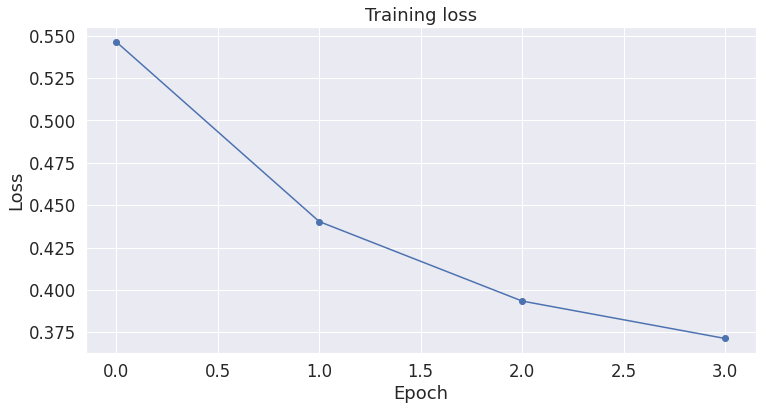

In [127]:
import matplotlib.pyplot as plt

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

### Evaluation

In [128]:
print('Predicting labels for {:,} test sentences...'.format(len(test_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions, true_labels = [], []

# Predict 
total_correct = 0
for idx, batch in enumerate(test_dataloader):
    
    print("Batch {}".format(idx + 1))
    
    # Add batch to device
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    # Get the prediction probability
    logits = outputs[0]
    
    # Get the prediction label
    pred = torch.argmax(logits, dim=1)
   
    # Get the number of correct predictions in this batch
    batch_correct = (pred == b_labels).sum().item()
    print("Batch correct = {}\n".format(batch_correct))
    
    # Accumulate the number of correct predictions over all batches
    total_correct += batch_correct
    
    # Append the predicted labels and true labels for this batch
    predictions.append(pred.cpu().numpy())
    true_labels.append(b_labels.cpu().numpy())
    

print('DONE.')
print("Total correct = ", total_correct)
print("Test accuracy = {0:.2f}".format(total_correct / len(test_inputs)))

# Concatenate the predicted labels and true labels over all batches
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Print classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(true_labels, predictions))
print(confusion_matrix(true_labels, predictions))

Predicting labels for 2,177 test sentences...
Batch 1
Batch correct = 9

Batch 2
Batch correct = 13

Batch 3
Batch correct = 7

Batch 4
Batch correct = 5

Batch 5
Batch correct = 10

Batch 6
Batch correct = 7

Batch 7
Batch correct = 9

Batch 8
Batch correct = 10

Batch 9
Batch correct = 3

Batch 10
Batch correct = 0

Batch 11
Batch correct = 8

Batch 12
Batch correct = 10

Batch 13
Batch correct = 10

Batch 14
Batch correct = 14

Batch 15
Batch correct = 14

Batch 16
Batch correct = 3

Batch 17
Batch correct = 0

Batch 18
Batch correct = 11

Batch 19
Batch correct = 14

Batch 20
Batch correct = 7

Batch 21
Batch correct = 4

Batch 22
Batch correct = 6

Batch 23
Batch correct = 5

Batch 24
Batch correct = 5

Batch 25
Batch correct = 7

Batch 26
Batch correct = 8

Batch 27
Batch correct = 8

Batch 28
Batch correct = 7

Batch 29
Batch correct = 7

Batch 30
Batch correct = 8

Batch 31
Batch correct = 4

Batch 32
Batch correct = 8

Batch 33
Batch correct = 7

Batch 34
Batch correct = 10

B